## Demo of scalable GPCs with additive noise on a binary case

In [1]:
import gpflow
import numpy as np
from likelihoods_GPCnoise import Binary_Unifying
from scipy.cluster.vq import kmeans
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages

### Load binary data

In [2]:
Xtrain = np.loadtxt('data/toy_binary_X_train', delimiter=',')
Ytrain = np.loadtxt('data/toy_binary_Y_train', delimiter=',').reshape(-1,1)
Ytrain[Ytrain==0] = -1 # convert y \in {0, 1} to {-1, 1}

### Train GPCs using step, probit and logit likelihoods

In [3]:
# Setup the experiment
a_list = [0., 1., 2.897] # a = 0 -> step likelihood
                                    # a = 1 -> probit likelihood
                                    # a = 2.897 -> logit likelihood
M = 32 # inducing size

# Run sparse classification
models = []
for index, a in enumerate(a_list):
    Z = kmeans(Xtrain, M)[0]

    m = gpflow.models.SVGP(Xtrain, Ytrain, Z=Z,
        kern=gpflow.kernels.Matern32(input_dim=2, lengthscales=0.5, ARD=True),
        likelihood=Binary_Unifying(a=a))
    m.likelihood.delta.trainable = True
    
    opt = gpflow.train.AdamOptimizer(0.01)
    opt.minimize(m, maxiter=5000)
    
    models.append(m)

### Make plots

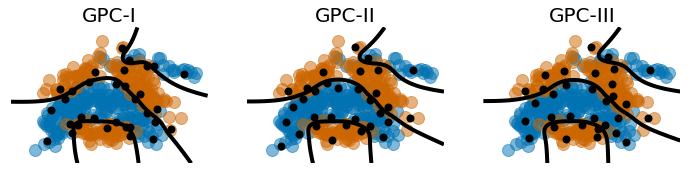

In [4]:
def gridParams():
    mins = [-3,-2.5] 
    maxs = [ 3, 3.0]
    nGrid = 100
    xspaced = np.linspace(mins[0], maxs[0], nGrid)
    yspaced = np.linspace(mins[1], maxs[1], nGrid)
    xx, yy = np.meshgrid(xspaced, yspaced)
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    return mins, maxs, xx, yy, Xplot

def plot(m, ax, title):
    col1 = '#0172B2'
    col2 = '#CC6600'
    mins, maxs, xx, yy, Xplot = gridParams()
    p = m.predict_y(Xplot)[0]
    ax.plot(Xtrain[:,0][Ytrain[:,0]==1], Xtrain[:,1][Ytrain[:,0]==1], 'o', color=col1, ms=12, alpha=0.5)
    ax.plot(Xtrain[:,0][Ytrain[:,0]==-1], Xtrain[:,1][Ytrain[:,0]==0-1], 'o', color=col2, ms=12, alpha=0.5)
    Z = m.feature.Z.read_value()
    ax.plot(Z[:,0], Z[:,1], 'ko', mew=0, ms=8)
    ax.set_title(title, fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.contour(xx, yy, p.reshape(*xx.shape), [0.5], colors='k', linewidths=4, zorder=100)

pdf = PdfPages('demo_binary.pdf')

fig, axes = plt.subplots(1, len(models), figsize=(12, 2.5), sharex=True, sharey=True)
titles = ['GPC-I','GPC-II','GPC-III']
for i, m in enumerate(models):
    plot(m, axes[i], titles[i])
    axes[i].set_yticks([])
    axes[i].set_xticks([])
pdf.savefig()
pdf.close()